<a href="https://colab.research.google.com/github/fedhere/covid19Vizs/blob/master/COVID19LOS_featureExtractionRFexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# example of how to use random forest (regressor) and extract important features from the model - authored by @fedhere & @gdobler on 09/2020 for Tze and Keshab LOS analysis

In [89]:
import pandas as pd
import numpy as np
import seaborn
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# creating mock data based on the data dictionary you gave us. 

In [36]:
mockdatadf = pd.DataFrame(columns=["Age", "Sex", "HX_AIDS", "HX_ALCOHOL", 
                                  "HX_ANEMDEF", "HX_ARTH", "HX_BLDLOSS", 
                                  "HX_CAD", "HX_CARDARRH", "HX_CHF", 
                                  "HX_CHRNLUNG", "HX_COAG", "HX_DEPRESS", 
                                  "HX_DM", "HX_DMCX", "HX_DRUG", "HX_HTN", 
                                  "HX_HTNCX", "HX_HYPOTHY", "HX_LIVER", 
                                  "HX_LYMPH", "HX_LYTES", "HX_METS", "HX_NEURO", 
                                  "HX_OBESE", "HX_PARA", "HX_PERIVASC", 
                                  "HX_PSYCH", "HX_PULMCIRC", "HX_RENLFAIL", 
                                  "HX_TUMOR", "HX_ULCER", "HX_VALVE", 
                                  "HX_WGHTLOSS"])
mockdatadf

,Age,Sex,HX_AIDS,HX_ALCOHOL,HX_ANEMDEF,HX_ARTH,HX_BLDLOSS,HX_CAD,HX_CARDARRH,HX_CHF,HX_CHRNLUNG,HX_COAG,HX_DEPRESS,HX_DM,HX_DMCX,HX_DRUG,HX_HTN,HX_HTNCX,HX_HYPOTHY,HX_LIVER,HX_LYMPH,HX_LYTES,HX_METS,HX_NEURO,HX_OBESE,HX_PARA,HX_PERIVASC,HX_PSYCH,HX_PULMCIRC,HX_RENLFAIL,HX_TUMOR,HX_ULCER,HX_VALVE,HX_WGHTLOSS


In [50]:
np.random.seed(302)
tmp_ = np.random.randn(1400) * 15 + 60
tmp_ = tmp_[(tmp_ >= 18) & (tmp_ <= 100)]

mockdatadf["Age"] = tmp_[:700].astype(int)

for c in mockdatadf.columns[1:]:
  mockdatadf[c] = np.random.randint(0, 2, 700)

#made a target variable that depends only on age and hypertension
mockdatadf["LOS"] = mockdatadf.Age * 0.1 + mockdatadf.HX_HTN * 3

In [51]:
mockdatadf.head()

,Age,Sex,HX_AIDS,HX_ALCOHOL,HX_ANEMDEF,HX_ARTH,HX_BLDLOSS,HX_CAD,HX_CARDARRH,HX_CHF,HX_CHRNLUNG,HX_COAG,HX_DEPRESS,HX_DM,HX_DMCX,HX_DRUG,HX_HTN,HX_HTNCX,HX_HYPOTHY,HX_LIVER,HX_LYMPH,HX_LYTES,HX_METS,HX_NEURO,HX_OBESE,HX_PARA,HX_PERIVASC,HX_PSYCH,HX_PULMCIRC,HX_RENLFAIL,HX_TUMOR,HX_ULCER,HX_VALVE,HX_WGHTLOSS,LOS
0,76,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0,7.6
1,66,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,6.6
2,78,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,7.8
3,47,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,7.7
4,96,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,1,1,1,1,0,0,0,1,1,0,1,1,12.6


In [52]:
mockdatadf.tail()

,Age,Sex,HX_AIDS,HX_ALCOHOL,HX_ANEMDEF,HX_ARTH,HX_BLDLOSS,HX_CAD,HX_CARDARRH,HX_CHF,HX_CHRNLUNG,HX_COAG,HX_DEPRESS,HX_DM,HX_DMCX,HX_DRUG,HX_HTN,HX_HTNCX,HX_HYPOTHY,HX_LIVER,HX_LYMPH,HX_LYTES,HX_METS,HX_NEURO,HX_OBESE,HX_PARA,HX_PERIVASC,HX_PSYCH,HX_PULMCIRC,HX_RENLFAIL,HX_TUMOR,HX_ULCER,HX_VALVE,HX_WGHTLOSS,LOS
695,71,1,0,0,0,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,0,1,0,0,1,1,1,0,10.1
696,63,1,0,1,1,0,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,9.3
697,41,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,7.1
698,53,0,0,1,0,1,1,0,1,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,0,1,5.3
699,62,1,1,0,0,0,1,0,1,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,9.2


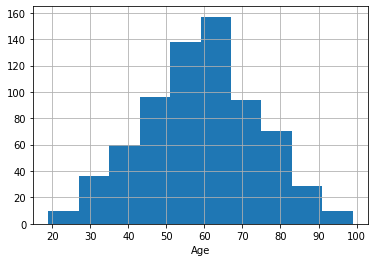

In [58]:
ax = mockdatadf.Age.hist();
ax.set_xlabel("Age");

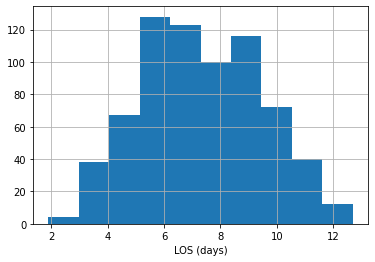

In [59]:
ax = mockdatadf.LOS.hist();
ax.set_xlabel("LOS (days)");

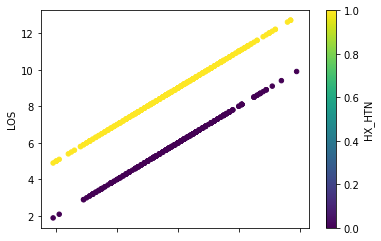

In [70]:
mockdatadf.plot.scatter(x="Age", y="LOS", c="HX_HTN", cmap="viridis");
ax.set_ylabel("LOS (days)");
ax.set_xlabel("Age");

In [96]:
# creating a cmpletely covariant feature: setting obesity to be equal to hypertension

mockdatadf["HX_OBESE"] = mockdatadf["HX_HTN"]

In [97]:
nrows, ncols = mockdatadf.shape
print("The shape of the dataframe is nrows: {}, ncolumns: {}".format(*mockdatadf.shape))

The shape of the dataframe is nrows: 700, ncolumns: 35


In [98]:
# quick data cleaning: remove NaN (we have none)
# note that this drops the entire row if there is a NaN. we can modify it if you want to drop the column or replace the cell value
mockdatadf.dropna(inplace=True)
mockdatadf.shape

(700, 35)

In [99]:
print("I lost {} observations in cleaning, {:.0f}% of the dataset".format(nrows - mockdatadf.shape[0], (nrows - mockdatadf.shape[0]) / nrows * 100))

I lost 0 observations in cleaning, 0% of the dataset


because i want to predict the LOS cases in this mock example, I will use the random forest regression model in sklearn ```RandomForestRegressor```. If I had a binary target variable (e.g. the death outcome) then I would use the random forest classifier model ```RandomForestClassifier```

In [117]:
from sklearn.ensemble import RandomForestRegressor
# look here for usage  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [118]:
# i need to normalize the target variable so i can use the mean sq error as a diagnostic for model success
targetmean, targetstd = mockdatadf.LOS.mean(), mockdatadf.LOS.std()

In [150]:
# I don't need to worry a lot about standardizing the features in a random forest because each feature is treated separately. 
# Models that combine features mathematically require the features to be standardized (or ideally whitened to remove correlation)
# But random forest implement decisions on a single feature at a time: its a family of independent binary decision trees

# splitting into training ant test set (80% training, 20% test)

features = mockdatadf.drop(["LOS"], axis=1)
target = (mockdatadf.LOS - targetmean) / targetstd

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
  features, target, test_size=0.2, random_state=302)



In [151]:
# control the depth of each tree in the forest to avoid overfitting
regr = RandomForestRegressor(max_depth=3, random_state=302)
regr.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=302, verbose=0, warm_start=False)

In [152]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, regr.predict(X_test))

print("mean sq error of the model {:.2f} ({:.0f}%)".format(
    mse, mse * 100))

mean sq error of the model 0.03 (3%)


In [153]:
# If I wanted the predictions I would do 
(regr.predict(X_test) * targetstd + targetmean).astype(int)

array([ 6, 10,  9,  6,  6,  9,  8,  8,  5, 11, 11,  8,  9,  9,  8,  8,  6,
        9,  8,  6,  6,  3,  5,  5,  6,  5,  9,  9,  3,  3,  8,  9,  6,  5,
        6,  6,  8,  5,  5,  6,  5,  6,  6,  5,  5,  8,  5,  6,  5,  5,  6,
        5,  9,  5,  8,  6,  8,  5,  8, 11,  8,  8,  7,  7,  8,  6,  5,  9,
        4,  6,  9,  3,  6,  9,  9,  6,  7,  6,  8,  5,  3,  5,  6,  8,  9,
        8,  7,  8,  6,  6,  5,  3,  8,  6,  8,  3,  6, 11,  3,  5,  6,  4,
       11,  6,  9,  8,  8,  3,  8,  6,  3,  3,  8, 11,  5,  5,  5,  8,  8,
        8,  6,  3,  8, 11,  6,  8,  3,  3, 11,  6,  6,  6, 11,  6,  6,  6,
        5,  3,  8,  9])

# feature importance

In [154]:
regr.feature_importances_, features.columns

(array([0.47624401, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.23155088, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.29220511,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 Index(['Age', 'Sex', 'HX_AIDS', 'HX_ALCOHOL', 'HX_ANEMDEF', 'HX_ARTH',
        'HX_BLDLOSS', 'HX_CAD', 'HX_CARDARRH', 'HX_CHF', 'HX_CHRNLUNG',
        'HX_COAG', 'HX_DEPRESS', 'HX_DM', 'HX_DMCX', 'HX_DRUG', 'HX_HTN',
        'HX_HTNCX', 'HX_HYPOTHY', 'HX_LIVER', 'HX_LYMPH', 'HX_LYTES', 'HX_METS',
        'HX_NEURO', 'HX_OBESE', 'HX_PARA', 'HX_PERIVASC', 'HX_PSYCH',
        'HX_PULMCIRC', 'HX_RENLFAIL', 'HX_TUMOR', 'HX_ULCER', 'HX_VALVE',
        'HX_WGHTLOSS'],
       dtype='object'))

Feature ranking:


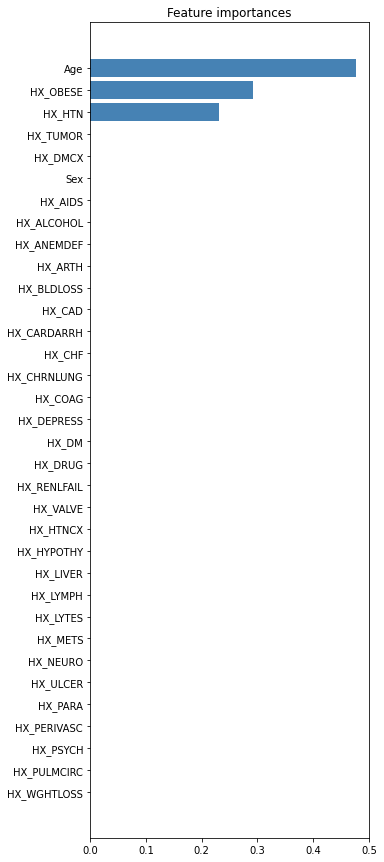

1. feature HX_WGHTLOSS: 0.48
2. feature HX_PULMCIRC: 0.29
3. feature HX_PSYCH: 0.23
4. feature HX_PERIVASC: 0.00
5. feature HX_PARA: 0.00
6. feature HX_ULCER: 0.00
7. feature HX_NEURO: 0.00
8. feature HX_METS: 0.00
9. feature HX_LYTES: 0.00
10. feature HX_LYMPH: 0.00
11. feature HX_LIVER: 0.00
12. feature HX_HYPOTHY: 0.00
13. feature HX_HTNCX: 0.00
14. feature HX_VALVE: 0.00
15. feature HX_RENLFAIL: 0.00
16. feature HX_DRUG: 0.00
17. feature HX_DM: 0.00
18. feature HX_DEPRESS: 0.00
19. feature HX_COAG: 0.00
20. feature HX_CHRNLUNG: 0.00
21. feature HX_CHF: 0.00
22. feature HX_CARDARRH: 0.00
23. feature HX_CAD: 0.00
24. feature HX_BLDLOSS: 0.00
25. feature HX_ARTH: 0.00
26. feature HX_ANEMDEF: 0.00
27. feature HX_ALCOHOL: 0.00
28. feature HX_AIDS: 0.00
29. feature Sex: 0.00
30. feature HX_DMCX: 0.00
31. feature HX_TUMOR: 0.00
32. feature HX_HTN: 0.00
33. feature HX_OBESE: 0.00
34. feature Age: 0.00


In [155]:
# Print the feature ranking
# creating an index to sort features 
# from the most important (highest value) of regr.feature_importances_ to the least important (lowest value)
indices = np.argsort(regr.feature_importances_) 

columns = features.columns[indices] # the colun names ordered by importance

print("Feature ranking:")

# Plot the impurity-based feature importances of the forest
plt.figure(figsize(5,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), regr.feature_importances_[indices],
        color="Steelblue", align="center")
plt.yticks(range(len(columns)), columns);
plt.show()

for i,f in enumerate(columns):
    print("{}. feature {}: {:.2f}".format(i + 1, f, 
                                   regr.feature_importances_[indices[::-1][i]]))
#[::-1] reverses index to have high importance first

The length of the bar represents the relative imporance. Importances sum to 1 so you can think of it as a percentage if you wish, but really you should not overinterpret the numnber. 
Note however a thing:  I want to predict LOS and hypertenson and obesity are covariant and both contribute to LOS identically. Each tree in the RF selects a subset of features to use, the trees that chose hypertention work exactly like the trees that choose obesity. The predictive power of the features is identical, so the importance is split between the 2. 


# rerun the model dropping one of the covariant features

In [156]:
features_noob = mockdatadf.drop(["LOS", "HX_OBESE"], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
  features_noob, target, test_size=0.2, random_state=302)



In [157]:
regr_noob = RandomForestRegressor(max_depth=3, random_state=302)
regr_noob.fit(X_train, y_train)
mse = mean_squared_error(y_test, regr_noob.predict(X_test))

print("mean sq error of the model {:.2f} ({:.0f}%)".format(
    mse, mse * 100))

mean sq error of the model 0.03 (3%)


# the fact that the accuracy did not get worse tells me that the feature is not important, in this case because it is entirely covariante with hypertension

Feature ranking:


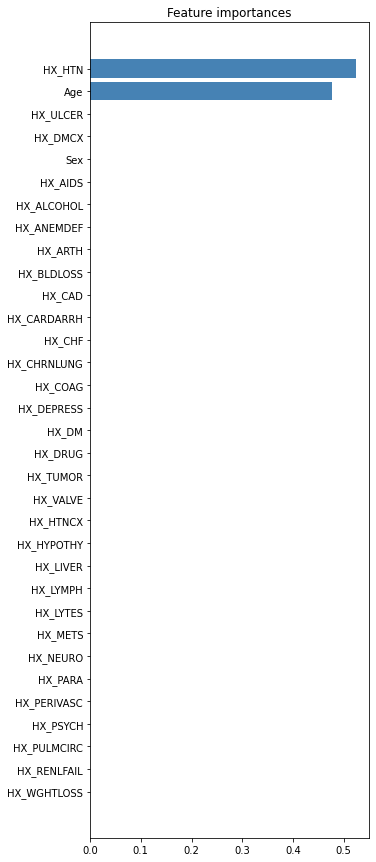

1. feature HX_WGHTLOSS: 0.52
2. feature HX_RENLFAIL: 0.48
3. feature HX_PULMCIRC: 0.00
4. feature HX_PSYCH: 0.00
5. feature HX_PERIVASC: 0.00
6. feature HX_PARA: 0.00
7. feature HX_NEURO: 0.00
8. feature HX_METS: 0.00
9. feature HX_LYTES: 0.00
10. feature HX_LYMPH: 0.00
11. feature HX_LIVER: 0.00
12. feature HX_HYPOTHY: 0.00
13. feature HX_HTNCX: 0.00
14. feature HX_VALVE: 0.00
15. feature HX_TUMOR: 0.00
16. feature HX_DRUG: 0.00
17. feature HX_DM: 0.00
18. feature HX_DEPRESS: 0.00
19. feature HX_COAG: 0.00
20. feature HX_CHRNLUNG: 0.00
21. feature HX_CHF: 0.00
22. feature HX_CARDARRH: 0.00
23. feature HX_CAD: 0.00
24. feature HX_BLDLOSS: 0.00
25. feature HX_ARTH: 0.00
26. feature HX_ANEMDEF: 0.00
27. feature HX_ALCOHOL: 0.00
28. feature HX_AIDS: 0.00
29. feature Sex: 0.00
30. feature HX_DMCX: 0.00
31. feature HX_ULCER: 0.00
32. feature Age: 0.00
33. feature HX_HTN: 0.00


In [158]:
indices = np.argsort(regr_noob.feature_importances_)

columns = features_noob.columns[indices] # the colun names ordered by importance

print("Feature ranking:")

# Plot the impurity-based feature importances of the forest
plt.figure(figsize(5,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), regr_noob.feature_importances_[indices],
        color="Steelblue", align="center")
plt.yticks(range(len(columns)), columns);
plt.show()

for i,f in enumerate(columns):
    print("{}. feature {}: {:.2f}".format(i + 1, f, 
                                   regr_noob.feature_importances_[indices[::-1][i]]))
    #[::-1] reverses index to have high importance first